### Check distribution of # of topics per document

Average number of topics per document: 3.6875860170657857
Max number of topics per document: 14
Min number of topics per document: 0


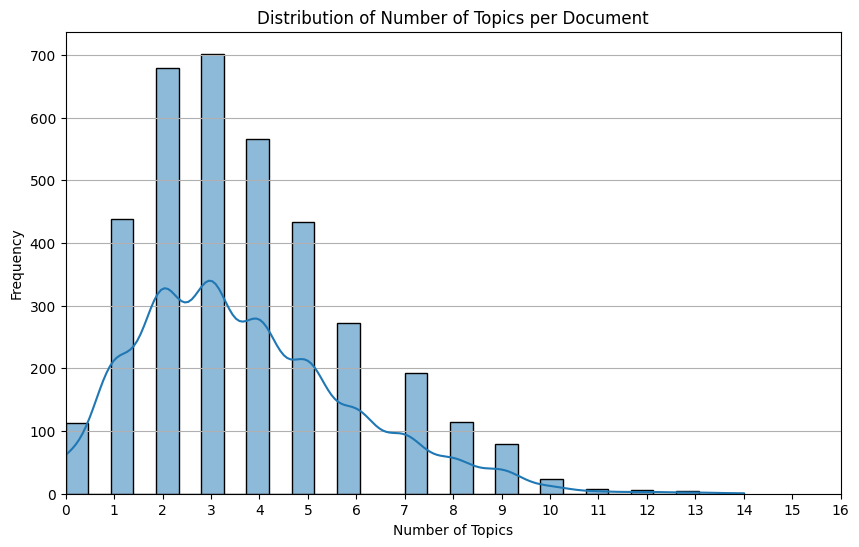

In [3]:
import json
with open("/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0605-biobert/doc_topics.jsonl", "r") as f:
    corpus_topic = [json.loads(line) for line in f]
# average of topic num
topic_num = []
for doc in corpus_topic:
    topic_num.append(len(doc['topics']))

print(f"Average number of topics per document: {sum(topic_num) / len(topic_num)}")
print(f"Max number of topics per document: {max(topic_num)}")
print(f"Min number of topics per document: {min(topic_num)}")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize=(10, 6))
sns.histplot(topic_num, bins=30, kde=True)
plt.title('Distribution of Number of Topics per Document')
plt.xlabel('Number of Topics')
plt.ylabel('Frequency')
plt.xlim(0, 16)
plt.xticks(np.arange(0, 17, 1))
plt.grid(axis='y')
plt.show()

### check topic info dataframe

In [4]:
import pandas as pd
TOPIC_INFO_PICKLE = "/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0605-biobert/topic_info_dataframe.pkl"

topic_info_df = pd.read_pickle(TOPIC_INFO_PICKLE)
display(topic_info_df)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,17309,-1_in_the_of_and,"[in, the, of, and, to, that, on, as, is, this,...",[OBJECTIVES: Our goal was to evaluate the asso...
1,0,1173,0_ci_95_95 ci_hr,"[ci, 95, 95 ci, hr, confidence interval, inter...",[The pooled multivariate hazard ratios for dea...
2,1,618,1_conclusions_conclusion_conclusions the_assoc...,"[conclusions, conclusion, conclusions the, ass...",[CONCLUSIONS: This large cohort study suggests...
3,2,415,2_assigned_assigned to_randomly_were randomly,"[assigned, assigned to, randomly, were randoml...",[Participants were randomly assigned to receiv...
4,3,408,3_questionnaire_food frequency_frequency quest...,"[questionnaire, food frequency, frequency ques...",[Diet was assessed at the study baseline using...
...,...,...,...,...,...
649,648,6,648_mmp_timp_mmp and_and timp,"[mmp, timp, mmp and, and timp, mmp mmp, mt1 mm...","[A significant decrease in MMP-13, MMP-3, MMP-..."
650,649,6,649_nutritive_non nutritive_polyphenolic antio...,"[nutritive, non nutritive, polyphenolic antiox...","[In conclusion, there is convincing evidence t..."
651,650,6,650_25 microm_microm_coincubation_gf120918,"[25 microm, microm, coincubation, gf120918, ti...",[Genistein inhibited lipid accumulation in a d...
652,651,6,651_light_uv_wavelength_light scattered,"[light, uv, wavelength, light scattered, by ab...",[CONCLUSIONS: Although the anterior portion of...


In [6]:
# write topic_info_df to a csv file
topic_info_df.to_csv("/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0605-biobert/topic_info_dataframe.csv", index=False)

### Filter Representation using POS tagging

In [2]:
import pandas as pd
TOPIC_INFO_PICKLE = "/home/guest/r12922050/GitHub/d2qplus/augmented-data/nfcorpus/topics/0605-biobert/topic_info_dataframe.pkl"

topic_info_df = pd.read_pickle(TOPIC_INFO_PICKLE)
display(topic_info_df)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,17309,-1_in_the_of_and,"[in, the, of, and, to, that, on, as, is, this,...",[OBJECTIVES: Our goal was to evaluate the asso...
1,0,1173,0_ci_95_95 ci_hr,"[ci, 95, 95 ci, hr, confidence interval, inter...",[The pooled multivariate hazard ratios for dea...
2,1,618,1_conclusions_conclusion_conclusions the_assoc...,"[conclusions, conclusion, conclusions the, ass...",[CONCLUSIONS: This large cohort study suggests...
3,2,415,2_assigned_assigned to_randomly_were randomly,"[assigned, assigned to, randomly, were randoml...",[Participants were randomly assigned to receiv...
4,3,408,3_questionnaire_food frequency_frequency quest...,"[questionnaire, food frequency, frequency ques...",[Diet was assessed at the study baseline using...
...,...,...,...,...,...
649,648,6,648_mmp_timp_mmp and_and timp,"[mmp, timp, mmp and, and timp, mmp mmp, mt1 mm...","[A significant decrease in MMP-13, MMP-3, MMP-..."
650,649,6,649_nutritive_non nutritive_polyphenolic antio...,"[nutritive, non nutritive, polyphenolic antiox...","[In conclusion, there is convincing evidence t..."
651,650,6,650_25 microm_microm_coincubation_gf120918,"[25 microm, microm, coincubation, gf120918, ti...",[Genistein inhibited lipid accumulation in a d...
652,651,6,651_light_uv_wavelength_light scattered,"[light, uv, wavelength, light scattered, by ab...",[CONCLUSIONS: Although the anterior portion of...


In [1]:
from itertools import product
from sklearn.model_selection import ParameterGrid
from bertopic import BERTopic
import numpy as np
import collections
import json

from nltk import sent_tokenize

chunk_mode = "sentence"
win_size, win_step = 4, 2
corpus_path = "/home/guest/r12922050/GitHub/d2qplus/data/nfcorpus/corpus.jsonl"
chunks, chunk_owner = [], []

doc2chunk_idx = collections.defaultdict(list)

def sliding_windows(sentences, size=4, step=2):
    """Yield overlapping sentence windows."""
    i = 0
    while i < len(sentences):
        chunk = " ".join(sentences[i : i + size]).strip()
        if chunk:
            yield chunk
        i += step

def chunk_document(text, mode="sentence", win_size=4, win_step=2):
    """
    Break `text` into chunks according to `mode`.
    Returns a list of string chunks.
    """
    sents = sent_tokenize(text)
    if mode == "sentence":
        return [s.strip() for s in sents if s.strip()]
    elif mode == "window":
        return list(sliding_windows(sents, size=win_size, step=win_step))
    else:
        raise ValueError(f"Unknown chunk_mode: {mode}")

with open(corpus_path, "r", encoding="utf-8") as f:
    for line in f:
        obj = json.loads(line)
        doc_id, text = obj.get("_id"), obj.get("text", "")
        if doc_id is None or not isinstance(text, str):
            continue
        doc_chunks = chunk_document(text, mode=chunk_mode, win_size=win_size, win_step=win_step)
        for ch in doc_chunks:
            idx = len(chunks)
            chunks.append(ch)
            chunk_owner.append(doc_id)
            doc2chunk_idx[doc_id].append(idx)

print(f"[{chunk_mode.upper()}] Built {len(chunks):,} chunks from {len(doc2chunk_idx):,} documents.")

/home/guest/r12922050/miniconda3/envs/bertopic/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SENTENCE] Built 35,130 chunks from 3,633 documents.


In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models import CoherenceModel
from sentence_transformers import SentenceTransformer
from bertopic.representation import KeyBERTInspired


search_space = {
    "min_topic_size": [5,10],
    "umap__n_neighbors": [15, 50],
    "hdbscan__min_cluster_size": [10, 30]
}

embedder = SentenceTransformer("dmis-lab/biobert-v1.1", device=0)

grid = ParameterGrid(search_space)
results = []

for p in grid:
    print("Evaluating parameters:", p)
    umap_model    = UMAP(n_neighbors=p["umap__n_neighbors"],
                         n_components=5, metric="cosine")
    hdbscan_model = HDBSCAN(min_cluster_size=p["hdbscan__min_cluster_size"],
                            metric="euclidean", prediction_data=True)
    topic_model   = BERTopic(embedding_model=embedder,
                             representation_model=KeyBERTInspired(),
                             n_gram_range=(1,2),
                             min_topic_size=p["min_topic_size"],
                             umap_model=umap_model,
                             hdbscan_model=hdbscan_model,
                             top_n_words=10,
                             verbose=True)
    topics, _ = topic_model.fit_transform(chunks)
        
    # top_words = [[w for w,_ in topic_model.get_topic(t)] 
    #              for t in topic_model.get_topics().keys()]
    # coh = CoherenceModel(topics=top_words, texts=chunks,
    #                      coherence='c_v').get_coherence()

    # uniq = len(set(sum(top_words, []))) / (len(top_words) * 10)  # diversity
    # score = 2 * coh * uniq / (coh + uniq)
    # print(f"Coherence: {coh:.4f}, Diversity: {uniq:.4f}, Score: {score:.4f}")
    # results.append((p, coh, uniq, score))

best = max(results, key=lambda x: x[-1])
print("best params:", best[0], "C_V:", best[1], "diversity:", best[2])


No sentence-transformers model found with name dmis-lab/biobert-v1.1. Creating a new one with mean pooling.
2025-06-05 14:58:55,701 - BERTopic - Embedding - Transforming documents to embeddings.


Evaluating parameters: {'hdbscan__min_cluster_size': 10, 'min_topic_size': 5, 'umap__n_neighbors': 15}


Batches: 100%|██████████| 1098/1098 [00:29<00:00, 36.74it/s]
2025-06-05 14:59:25,954 - BERTopic - Embedding - Completed ✓
2025-06-05 14:59:25,955 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-05 15:00:27,132 - BERTopic - Dimensionality - Completed ✓
2025-06-05 15:00:27,135 - BERTopic - Cluster - Start clustering the reduced embeddings
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PAR

ValueError: dictionary has to be provided if topics are to be used.